# Prepare the model

## Import dependencies

In [7]:
!pip install -q keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D,Input,Bidirectional,GRU,Flatten
from keras.optimizers import RMSprop
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model

import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,mean_squared_error


import csv
from pathlib import Path

import scipy.io
from scipy import signal

Using TensorFlow backend.


## Data loading functions

In [0]:
def read_own_data(name):
  # read signal data from certain people
  # raw signal saved in ./Data/name/eda.csv hr.csv 
  # label save in ./Data/name/label
  # output -- list_eda: a list contains all raw eda signals
  #           list_hr: a list contains all raw hr signals
  #           list_label: a list contains all labels
  #           (if he watch 3 ads, length of list should be 3)

    print(name)
    list_eda = []
    list_hr = []
    list_label = []

    # All the videos we prepared for experiment
    Videos = ['booty_shorts', 'ghost', 'shock', 'sniker', 'snicker', 'japan', 'panda', 'sprite', 'thai', 'ws']

    for video in Videos:
        # Load EDA data file
        EDA_data = []
        EDA_filePath = 'Data/' + name + '/' + video + '_' + name + '/EDA.csv'
        # Load HR data file
        HR_data = []
        HR_filePath = 'Data/' + name + '/' + video + '_' + name + '/HR.csv'
        # Load labels file
        label_filePath = 'Data/' + name + '/' + video + '_' + name + '/label.txt'

        # if the participant did not watch this video, then skip
        if not Path(EDA_filePath).exists():
            continue
        else:
            with open(EDA_filePath) as csvDataFile:
                csvReader = csv.reader(csvDataFile)
                # Read each row in the file and store in the list
                for row in csvReader:
                    EDA_data.append(row[0])
                # Remove the first 3 elements in the file
                for i in range(0, 3):
                    EDA_data.remove(EDA_data[0])
            list_eda.append(EDA_data)
            length = len(EDA_data)
            
            # Same methodology to load HR data
            with open(HR_filePath) as csvDataFile:
                csvReader = csv.reader(csvDataFile)
                for row in csvReader:
                    HR_data.append(row[0])
                # remove the first 2 elements
                for j in range(0, 2):
                    HR_data.remove(HR_data[0])
            
            # maybe inapproporiate to list
            HR_data = signal.resample(HR_data, length)        
            list_hr.append(HR_data)

            file = open(label_filePath, 'r')
            list_label.append(file.read())

    return list_eda, list_hr, list_label

In [0]:
def read_deap_data(participant_id):
  # read signal data from deap
  # deap data saved in ./deep_data
  # output  -- x_i: list or numpy contains i th signals. We choos 2 signals
  # there are 32 participants, participant_id is from '01' to '32'
  x = scipy.io.loadmat('./deap_data/data_preprocessed_matlab/s' + participant_id + '.mat')

  data = x['data']
  labels = x['labels']
  x_1 = np.squeeze(data[:,[36],:])  #GSR,40*8064 matrix(40 videos and 8064 datapoints)
  x_2 = np.squeeze(data[:,[38],:])  #BVP,40*8064 matrix(40 videos and 8064 datapoints)
  x_3 = np.squeeze(data[:,[34],:])  #zEMG (Zygomaticus Major EMG)
  x_4 = np.squeeze(data[:,[35],:])  #tEMG (Trapezius EMG)
  y = labels[:,[0,1]]  #valence/arousal channel,40*2 matrix(40 videos and 2 labels)
  
  return x_1,x_2,x_3,x_4,y

In [0]:
def categorise_emotion(y_true):
  # decription: return emotion for every true and predicted (valence,arousal) pair.
  # input->  y_true: (samples,2)
  # output-> emotion: (samples)
  y1 = np.zeros(len(y_true))
  for i in range(len(y_true)):
    y1[i] = quadrant(y_true[i,0],y_true[i,1])
  return y1

In [0]:
def quadrant(valence, arousal):
  # description: return emotion according to the valence and arousal value
  # input-> valence:scalar  arousal:scalar
  # output-> emotion:scalar
  if valence>4.5 and arousal>4.5 and valence<5.5 and arousal<5.5:
    emotion = 2 # neutral
  elif valence>5 and arousal>5:
    emotion = 0 # happy
  elif valence>5 and arousal<5:
    emotion = 3 # not identified
  elif valence<5 and arousal<5:
    emotion = 3 # not identified
  elif valence<5 and arousal>5:
    emotion = 1 # scared
  else:
    emotion= 3
  return emotion 

In [0]:
def read_data(names,source):
  # This part is to define which resource are we using
  # Own Experiment Data
  # or DEAP Data
  
  data1 = []
  data2 = []
  data3 = []
  data4 = []
  list_label = []
  for name in names:
    # if source is not DEAP, then we read own data
    if source != "DEAP":
      eda,hr,label = read_own_data(name)
      data1 += eda
      data2 += hr
      list_label += label
      
    # Read DEAP data
    else:
      gsr,bvp,zEMG,tEMG,label = read_deap_data(name)
      data1 += gsr.tolist()
      data2 += bvp.tolist()
      data3 += zEMG.tolist()
      data4 += tEMG.tolist()
      list_label += label.tolist()

  return data1,data2,data3,data4,list_label

## Data preprocessing funcitons

In [0]:
def one_hot(label,all_labels=3):
  # transform labels to one-hot version
  y_onehot = np.zeros((len(label),all_labels))
  b = np.eye(all_labels)
  for i in range(len(label)):
    la = int(label[i])
    y_onehot[i,:] = b[la,:]
  return y_onehot

def preprocess(x_all,label,maxlen,normalizer=True,data_source="DEAP"):
  # preprocess the signals
  # input-> x_all: all the signals
  # parameter-> nomalizer;data_source: if DEAP, don't process label
  # output->
  x = []
  for i,signals in enumerate(x_all):
    for j,sample in enumerate(signals):
      if normalizer:
        x_all[i][j] = sklearn.preprocessing.scale(sample)
     
    matrix = pad_sequences(x_all[i],maxlen=maxlen,dtype='float64',padding='post')  
    x.append(matrix)
  x = np.stack(x,axis=2)
  if data_source!="DEAP":
    y = one_hot(label,3)
  else:
    y = np.asarray(label)
  return x,y

## Method 1 to split train data and eval data

In [0]:
### PARAMETERS:
data_source = "own"
classify = True
# 3. use how many channels used to classify
channels= 2  # = 1 or 2 channels to use # Original 2
# 4. whether to normalize signals
normalizer = True
if data_source =="DEAP":
  maxlen = 8064
else:
  maxlen = 1500
  
### START READING
# read all data and put them together
if data_source!="DEAP":
  names = os.listdir('./Data')
  x_1,x_2,x_3,x_4,label = read_data(names,data_source) 
  x_all=[]
  x_all.append(x_1)
  x_all.append(x_2)
  x,y = preprocess(x_all,label,maxlen,normalizer=normalizer,data_source="own")

else:
  id = [str(i+1).zfill(2) for i in range(32)]
  x_1,x_2,x_3,x_4,label = read_data(id,data_source)
  x_all=[]
  x_all.append(x_1)
  x_all.append(x_2)
  x_all.append(x_3)
  x_all.append(x_4)
  x,y = preprocess(x_all[:channels],label,maxlen,normalizer=normalizer,data_source="DEAP")
  if classify == True:
    y = categorise_emotion(y)
    y = one_hot(y,4)

In [0]:
def kfold(model,classify,maxlen,k=5):    
  # split k folds to evaluate the data
  # input-> model: the model we predine; 
  # parameters: classify: regression/classification problem
  #             maxlen: length of signals
  #             k: k-fold
  index = range(len(y))
  n_splits= k
  kf = KFold(n_splits=n_splits,shuffle=True,random_state=2018)
  
  train_predict = np.zeros_like(y)
  i=0
  for train, eval in kf.split(index):
#     if i>0:
#       break

    i += 1
    print('folding %d -->>'%i)
    
    # split the data
    train_x = x[train]
    train_y = y[train]
    eval_x = x[eval]
    eval_y = y[eval]

    # train the data
    
    model.fit(train_x,train_y,eval_x,eval_y)
    eval_preds = model.get_sta()
    train_predict[eval] =  eval_preds
  
    # evlauate model trained on our own data
    if classify==True:
      score = accuracy_score(np.argmax(eval_y,axis=1),np.argmax(eval_preds,axis=1))
      model_evaluation(np.argmax(eval_y,axis=1),np.argmax(eval_preds,axis=1))
      
    # evaluate model trained on deap datas
    else:
      score =[]
      for i in range(y.shape[1]):
        score.append(mean_squared_error(eval_y[:,i],eval_preds[:,i]))
      print("Mean square error of valence and arousal:",score)
      model_evaluation(categorise_emotion(eval_y),categorise_emotion(eval_preds))
      
  return eval_y,eval_preds

## Method 2 to split train data and eval data

In [0]:
### PARAMETERS
data_source = "own"
classify = True

# 3. use how many channels used to classify
channels= 2   # = 1 or 2 channels to use # Original 2

# 4. whether to normalize signals
normalizer = False
maxlen = 1500

def kfold_people(model,k=5):
  # split k folds according to people to evaluate the data
  # input-> model: the model we predine; 
  # parameters:  k: k-fold
  names = os.listdir('./Data')
  # split 10 folds 
  index = range(len(names))
  n_splits= k
  kf = KFold(n_splits=n_splits,shuffle=True,random_state=2018)
  i=0

  for train, eval in kf.split(index):
    i += 1
    print('folding %d -->>'%i)
    # split the data
    train_names = [names[ii]for ii in train]
    x_eda,x_hr,x3,x4,label = read_data(train_names,data_source) 
    x_all=[]
    x_all.append(x_eda)
    x_all.append(x_hr)
    train_x,train_y = preprocess(x_all,label,maxlen,normalizer=normalizer,data_source="own")
    eval_names = [names[ii]for ii in eval]
    x_eda,x_hr,x3,x4,label = read_data(eval_names,data_source) 
    x_all=[]
    x_all.append(x_eda)
    x_all.append(x_hr)
    eval_x,eval_y = preprocess(x_all,label,maxlen,normalizer=normalizer,data_source="own")
    
    # train the data 
    model.fit(train_x,train_y,eval_x,eval_y)
    eval_preds = model.get_sta()
  
    # evlauate model trained on our own data
    score = accuracy_score(np.argmax(eval_y,axis=1),np.argmax(eval_preds,axis=1))
    print('Accuracy of %s is : %f'%(model.get_name(),score))
#     model_evaluation(np.argmax(eval_y,axis=1),np.argmax(eval_preds,axis=1))
      
  return eval_y,eval_preds

## Evaluation functions

In [0]:
# Loss History
import matplotlib.pyplot as plt
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, classify):
         
        iters = range(len(self.losses[loss_type]))
        plt.figure()
#         if classify:
#           acc
#           plt.plot(iters[1:], self.accuracy[loss_type][1:], 'r', label='train acc')
          # val_acc
#           plt.plot(iters[1:], self.val_acc[loss_type][1:], 'b', label='val acc')
        
        # loss
        plt.plot(iters[1:], self.losses[loss_type][1:], 'g', label='train loss')
        # val_loss
        plt.plot(iters[1:], self.val_loss[loss_type][1:], 'k', label='val loss')
        
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()
        
        
# Evaluation of the results        
        
def plot_summary_table(cell_text):
    
    rows = ['Happy','Scared','Neutral', 'Not_identified','Overall']
    columns = ['# True','# Predict','Precision', 'Recall','F1']
   
    # Generate Table.
    fig=plt.figure(frameon=False)
    ax = plt.gca()
    the_table = ax.table(
        cellText=cell_text,
        rowLabels=rows,
        colLabels=columns,
        loc='center')
    the_table.scale(1, 4)
    # Prettify.
    ax.patch.set_facecolor('None')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
def model_evaluation(y,ypreds):
    # Input is one-dim prediction, class={0,1,2,3}
    result = np.zeros((4,4),dtype='float32')
    for s in range(len(y)): 
        result[int(y[s])][int(ypreds[s])] += 1
    
    # calculate accuracy
    correct_prediction = np.equal(y,ypreds)
    accuracy = np.mean(np.array(correct_prediction, dtype = np.float32))
    print("Average accuracy is: ", accuracy)
    
    # calculate f1-score
    print("F1-score:")
    text = np.zeros((5,5),dtype='float32')
    for i in range(4):
        text[i,0] = np.sum(result[i,:])   # true numbers
        text[i,1] = np.sum(result[:,i])   # prediction numbers
        text[i,2] = result[i][i] / (0.001 + np.sum(result[:,i]))  # precision
        text[i,3] = result[i][i] / (0.001 + np.sum(result[i,:]))  # recall
        text[i,4] = 2*text[i,2]*text[i,3]/(text[i,2]+text[i,3]+0.001) # f1-score
    text[4,0] = np.sum(text[:4,0]) 
    text[4,1] = np.sum(text[:4,1])
    true = result[0][0]+result[1][1]+result[2][2]+result[3][3]
    text[4,2] = float(true)/text[4,1]
    text[4,3] = float(true)/text[4,0]
    text[4,4] = 2*text[4,2]*text[4,3]/(text[4,2]+text[4,3]+0.001)
    plot_summary_table(text)
    return


## Model Definition

In [0]:
# define model

class LSTM:
  def __init__(self,filters=[(64,8,2)],hidden_units=32,maxlen=1500,channels=3,batch_size=64,epoch=2,classify=True):
    self.eval_preds = 0
    self.accuracy = 0
    self.name = 'GRU'
    self.filters = filters
    self.hidden_units = hidden_units
    self.maxlen = maxlen
    self.channels = channels
    self.batch_size = batch_size
    self.epoch = epoch
    self.classify=classify
    return
  
  def fit(self,train_x,train_y,eval_x,eval_y):
    # training process
    self.eval_preds = np.zeros((eval_x.shape[0],1))
    self.accuracy = np.zeros((1,))
    from keras import backend as K
    K.clear_session()
    def model_define():
      # input layer
      inp = Input(shape=(self.maxlen,self.channels))   
      # convolutional layers
      for i,(nb_filt,filt_len,maxpool_size) in enumerate(self.filters):
        if i==0:
          conv = Conv1D(activation="tanh", filters=nb_filt, kernel_size=filt_len)(inp)
          conv = MaxPooling1D(pool_size=maxpool_size)(conv)
        else:
          conv = Conv1D(activation="tanh", filters=nb_filt, kernel_size=filt_len)(conv)
          conv = MaxPooling1D(pool_size=maxpool_size)(conv)
      # dropout to avoid overfitting
      conv = Dropout(0.2)(conv)
      # Bidirctional RNN layers
      x = Bidirectional(GRU(self.hidden_units, return_sequences=True))(conv)
      # dropout to avoid overfitting
      x = Dropout(0.2)(x)
      flat = Flatten()(x)
      # fully-connected layer
      flat = Dense(32, activation="relu")(flat)
      # if problem is classification, output with softmax, loss function is crossentropy
      if self.classify==True:
        print("Train on Model: Classification Bidirectional GRU")
        outp = Dense(train_y.shape[1], activation="softmax")(flat)
        model = Model(inputs=inp, outputs=outp)
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  
      # if problem is regression, loss function is mean square error
      else:
        print("Train on Model: Regression Bidirectional GRU")
        outp = Dense(2, activation="linear")(flat)
        model = Model(inputs=inp, outputs=outp)
        model.compile(loss='mse', optimizer='rmsprop') 
        
      return model
    
    model=model_define()
    
    history = LossHistory()
    
    model.fit(train_x, train_y, batch_size=self.batch_size, epochs=self.epoch, validation_data=(eval_x,eval_y),callbacks=[history])
    if self.classify==True:
      history.loss_plot('batch',classify=True)
    else:
      history.loss_plot('batch',classify=False)
    
    self.eval_preds = model.predict(eval_x,batch_size=1024)
    return
    
  def get_sta(self):
    return self.eval_preds
  def get_name(self):
    return self.name

# Run the model

folding 1 -->>
Train on Model: Regression Bidirectional GRU
Train on 1024 samples, validate on 256 samples
Epoch 1/2
1024/1024 [==============================] - 29s 29ms/step - loss: 17.9575 - val_loss: 5.9609
Epoch 2/2
1024/1024 [==============================] - 28s 27ms/step - loss: 5.8553 - val_loss: 5.6762


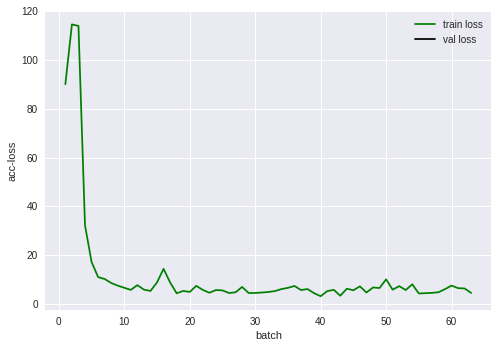

Mean square error of valence and arousal: [6.021623313099481, 5.330818007060264]
Average accuracy is:  0.30859375
F1-score:
folding 2 -->>
Train on Model: Regression Bidirectional GRU
Train on 1024 samples, validate on 256 samples
Epoch 1/2
1024/1024 [==============================] - 30s 29ms/step - loss: 14.7774 - val_loss: 5.9964
Epoch 2/2
1024/1024 [==============================] - 28s 27ms/step - loss: 5.7967 - val_loss: 10.1549


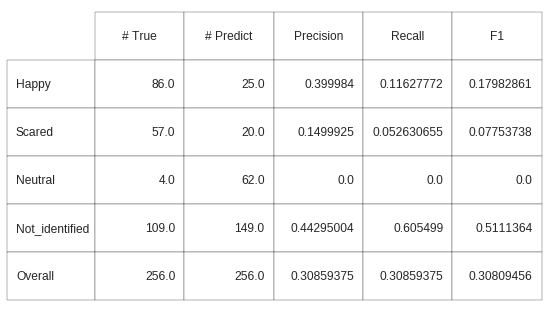

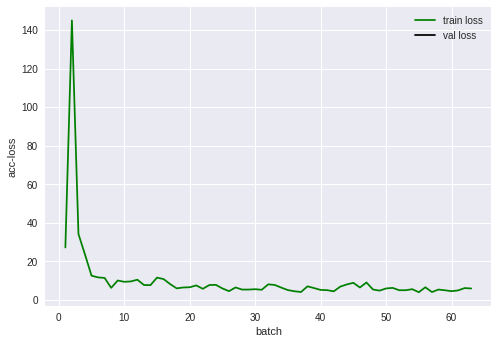

Mean square error of valence and arousal: [9.164946551530473, 11.144779789013352]
Average accuracy is:  0.37890625
F1-score:
folding 2 -->>
Train on Model: Regression Bidirectional GRU
Train on 1024 samples, validate on 256 samples
Epoch 1/2
1024/1024 [==============================] - 30s 29ms/step - loss: 10.9382 - val_loss: 7.9350
Epoch 2/2
1024/1024 [==============================] - 29s 28ms/step - loss: 5.5796 - val_loss: 5.6961


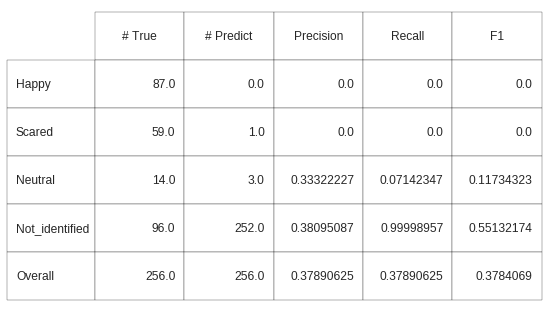

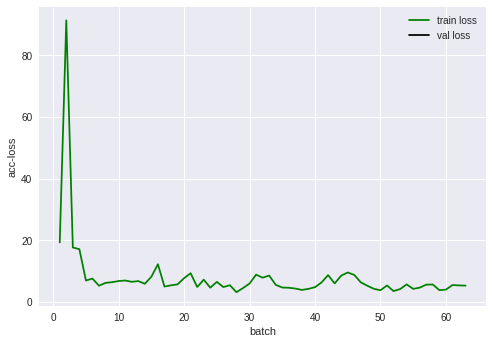

Mean square error of valence and arousal: [5.711257752196541, 5.680852126890925]
Average accuracy is:  0.37109375
F1-score:
folding 2 -->>
Train on Model: Regression Bidirectional GRU
Train on 1024 samples, validate on 256 samples
Epoch 1/2
1024/1024 [==============================] - 30s 29ms/step - loss: 19.5291 - val_loss: 11.1473
Epoch 2/2
1024/1024 [==============================] - 28s 28ms/step - loss: 6.2869 - val_loss: 6.5302


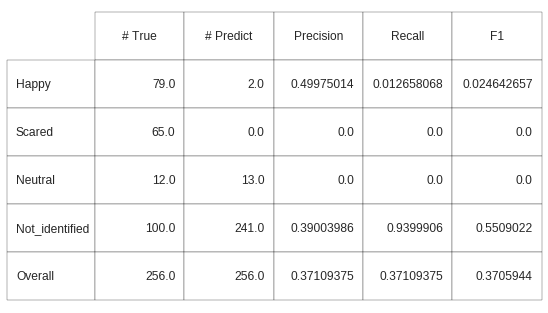

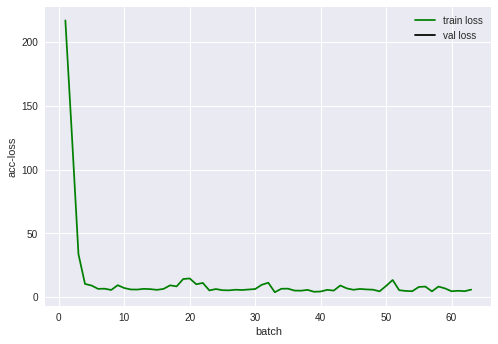

Mean square error of valence and arousal: [6.1004850047299835, 6.9598855236799455]
Average accuracy is:  0.30078125
F1-score:
folding 2 -->>
Train on Model: Regression Bidirectional GRU
Train on 1024 samples, validate on 256 samples
Epoch 1/2
1024/1024 [==============================] - 30s 29ms/step - loss: 12.7494 - val_loss: 6.4561
Epoch 2/2
1024/1024 [==============================] - 29s 28ms/step - loss: 5.8456 - val_loss: 6.3083


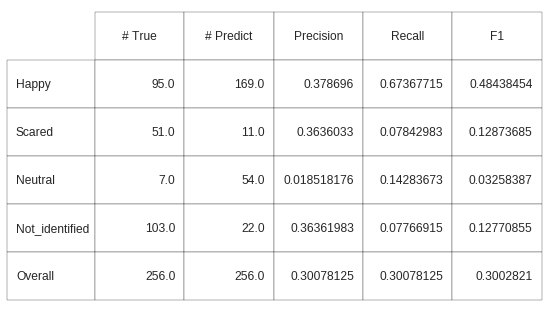

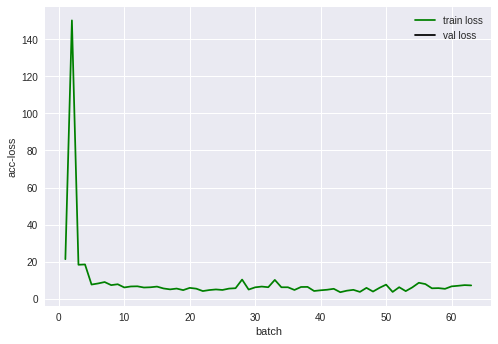

Mean square error of valence and arousal: [5.825499227322528, 6.791041754043903]
Average accuracy is:  0.44140625
F1-score:


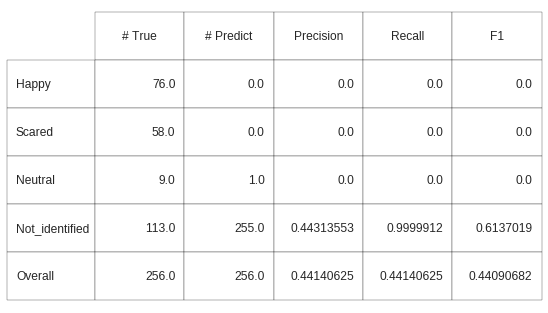

In [27]:
# Tuning parameters

# 1. filter_shape (filter_pulse,kernle_size,max_pooling_size) for a single layer, can add more layers in this list
filters= [(32,4,2),(32,4,2),(32,4,2),(32,4,2)]     # Original [(32,4,2),(32,4,2),(32,4,2)]  

# 2. hidden_units for LSTM
hidden_units=32  # Original = 32 

# 5. batch_size
batch_size = 32 #[32,64,128]   # Original 32

# 6. epoch
epoch = 2  #[1,2,3,4] # Original 2

# define model
model = LSTM(filters,hidden_units,maxlen,channels,batch_size,epoch,classify=classify)
ee1,ee2 = kfold(model,classify,maxlen,k=5)
# ee1,ee2 = kfold_people(model,k=5)